In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import norm
from matplotlib import lines

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm

from ast import literal_eval


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
def plot_gdf(boo, soo, gdfs, gdf_numbers_to_plot=None):
    mid_price = (max(boo[:, 0]) + min(soo[:, 0])) / 2
    size = np.max(boo[:, 1])
    size = np.max([size, np.max(soo[:, 1])])
    
    fig = plt.figure(figsize=(16, 4))
    plt.bar(boo[:, 0][-50:-1], boo[:, 1][-50:-1], width=-0.1, align='edge', edgecolor=['b'], label='buy orders')
    plt.bar(soo[:, 0][0:50], soo[:, 1][0:50], width=0.1, align='edge', edgecolor=['r'], label='sell orders')
    plt.vlines(mid_price, 0, 0.04, linestyles='dashed', label='mid price')
    if not gdf_numbers_to_plot:
        gdf_numbers_to_plot = [10, 20, 30, 40]
    for i in gdf_numbers_to_plot:
        gdf_x = np.linspace(boo[-50:,0].min(), soo[:50, 0].max(), 2000)
        gdf_y = gdfs[i, 0] * norm.pdf(gdf_x, loc=gdfs[i, 1], scale=gdfs[i, 2])
        a = gdf_representation(boo, soo, gdfs[i])

        plt.plot(gdf_x, gdf_y, label='Gaussian curve $(\mu_{%s}, \sigma) %s $' % (i, size))
    plt.xlim(-4, 4)
    plt.legend()
    plt.title('Gaussian Density Filter example')
    plt.tight_layout()

In [3]:
def normalize_limit_order_book(buy_orders, sell_orders):
    buy_orders = np.array(buy_orders)
    sell_orders = np.array(sell_orders)
    mid_price = (buy_orders[-1, 0] + sell_orders[0, 0]) / 2.0

    if(buy_orders.shape[0] > 0):
        buy_orders[:, 1] = buy_orders[:, 0] * buy_orders[:, 1]
        buy_orders[:, 0] = 1000.0 * (buy_orders[:, 0] - mid_price) / mid_price

    if(sell_orders.shape[0] > 0):
        sell_orders[:, 1] = sell_orders[:, 0] * sell_orders[:, 1]
        sell_orders[:, 0] = 1000.0 * (sell_orders[:, 0] - mid_price) / mid_price

    total_capital = buy_orders[:, 1].sum() + sell_orders[:, 1].sum()
    buy_orders[:, 1] /= total_capital
    sell_orders[:, 1] /= total_capital

    return buy_orders, sell_orders

In [4]:
def get_gdfs(r, s):
    K = 50
    gdfs_r = r * np.ones(K)
    gdfs_m = 0.1000 * np.hstack([np.arange(- K // 2, 0), np.arange(0, K // 2 )])
    gdfs_s = s * np.ones(K)
    gdfs = np.vstack([gdfs_r, gdfs_m, gdfs_s]).T
    return gdfs

In [5]:
def is_all_gdfs_not_clipped(buy_orders, sell_orders, gdfs):
    for i in range(len(gdfs)):
        gdf, max_ = gdf_representation(buy_orders, sell_orders, gdfs[i])
        if max_ < 0:
            print('Found number', i, gdf, max_buy, max_sell)
            return False
    return True

In [6]:
def gdf_representation(buy_orders, sell_orders, gdf, should_plot=False):
    all_orders = np.append(buy_orders, sell_orders, axis=0)
    size = np.max(buy_orders[:, 1])
    sell_gdf_y = gdf[0] * norm.pdf(all_orders[:, 0], loc=gdf[1], scale=gdf[2])
    max_sell_gdf_idx = np.argmax(sell_gdf_y)
    if should_plot:
        plt.figure(figsize=(16,4))
        plt.plot(sell_gdf_y, label='ask+sell pdf', alpha=1.0)
        plt.plot(np.clip(all_orders[:, 1], 0.0, sell_gdf_y), '-.', label='ask+sell clip', alpha=1.0)

        plt.legend()
    clipped = np.clip(all_orders[:, 1], 0.0, sell_gdf_y).sum()
    max_sell_not_clipped = clipped
    return clipped, max_sell_not_clipped

In [7]:
def gdf_representation2(buy_orders, sell_orders, gdf, should_plot=False):
    buy_gdf_y = gdf[0] * norm.pdf(buy_orders[:, 0], loc=gdf[1], scale=gdf[2])
    sell_gdf_y = gdf[0] * norm.pdf(sell_orders[:, 0], loc=gdf[1], scale=gdf[2])

    if should_plot:
        plt.figure(figsize=(16,4))
        plt.plot(buy_gdf_y, label='bid pdf', alpha=1.0)
        plt.plot(sell_gdf_y, label='sell pdf', alpha=1.0)
        plt.plot(np.clip(buy_orders[:, 1], 0.0, buy_gdf_y), '-.', label='ask clip', alpha=1.0)
        plt.plot(np.clip(sell_orders[:, 1], 0.0, sell_gdf_y), '-.', label='sell clip', alpha=1.0)
        plt.legend()

    return np.clip(buy_orders[:, 1], 0.0, buy_gdf_y).sum() + np.clip(sell_orders[:, 1], 0.0, sell_gdf_y).sum(), 0

rs 0.18415435710545652 0.5524630713163696
(0.057732925506417815, 0)
(0.057732925506417815, 0.057732925506417815)


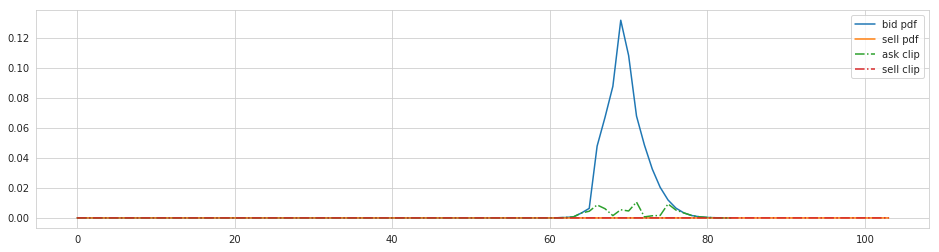

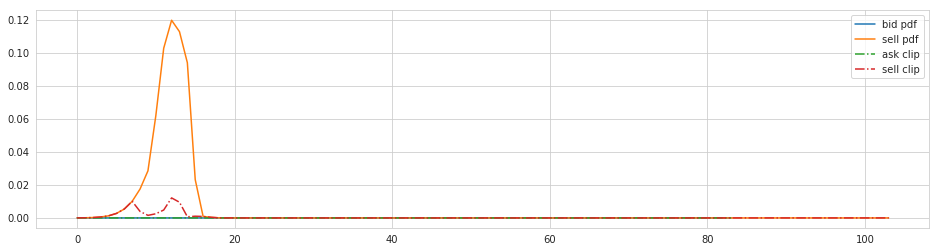

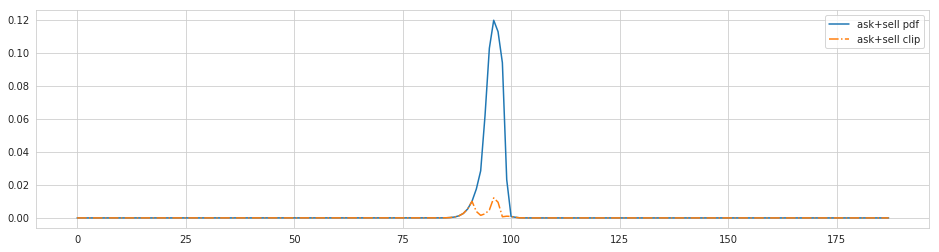

In [8]:
stocks = ['9061']
data_length = 15000
for stock in stocks:
    df, df_test = lob.load_prepared_data(
        stock, data_dir='../queue_imbalance/data/prepared/', cv=False, include_test=True, length=data_length)
    
    buy_orders, sell_orders = normalize_limit_order_book(literal_eval(df.iloc[0]['bid']), 
                                                         literal_eval(df.iloc[0]['ask']))
    r = 3 * np.max([np.max(buy_orders[:, 1]), np.max(sell_orders[:, 1])])
    s = 3 * r
    print('rs', r,s)
    gdfs = get_gdfs(r, s)
    
    a = gdf_representation2(buy_orders, sell_orders, gdfs[0], should_plot=True)
    a = gdf_representation2(buy_orders, sell_orders, gdfs[49], should_plot=True)
    print(a)
    a = gdf_representation(buy_orders, sell_orders, gdfs[49], should_plot=True)
print(a)

True
True
True
True
True
True


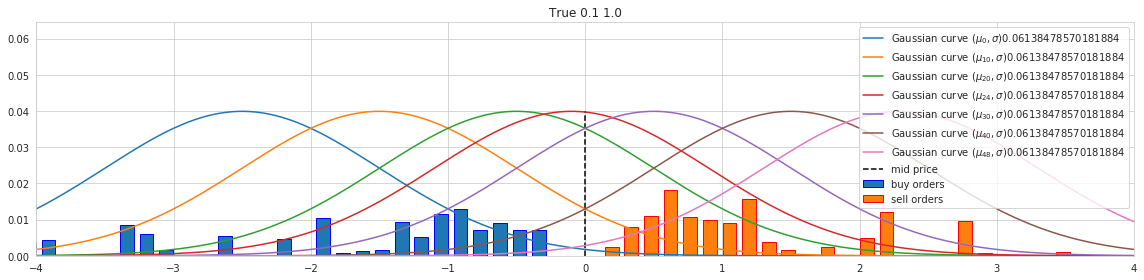

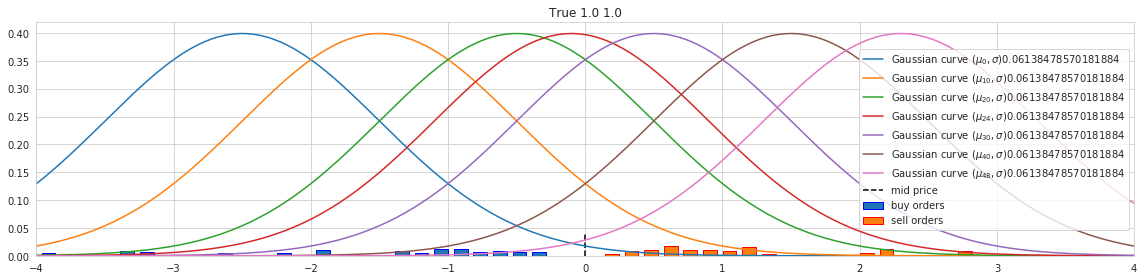

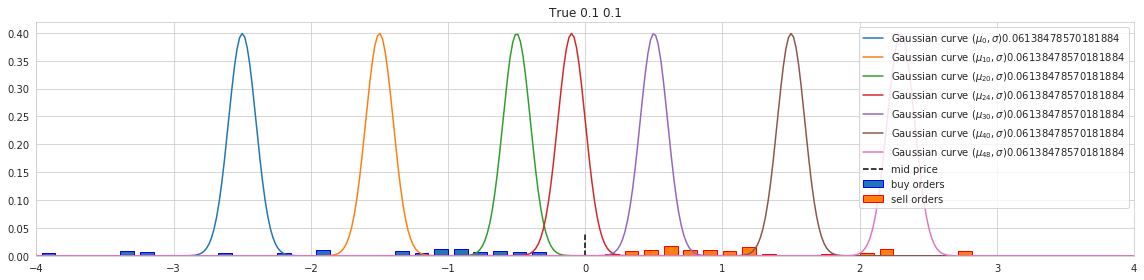

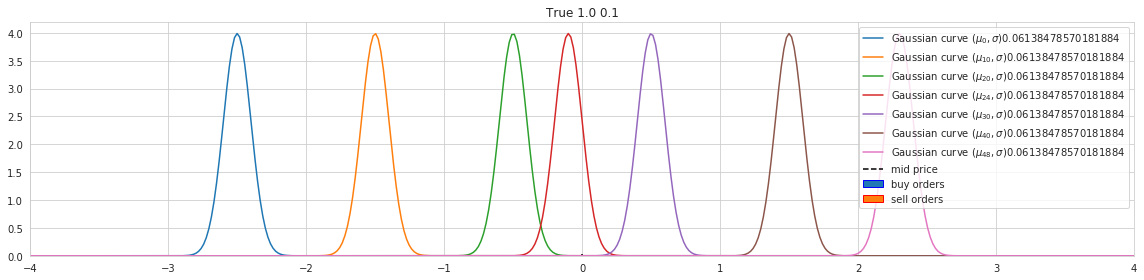

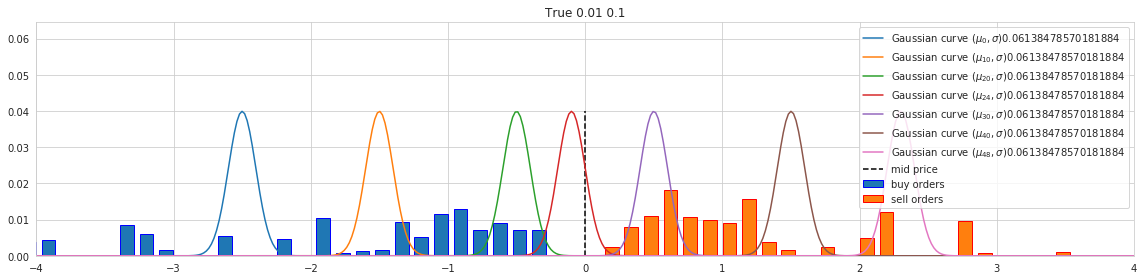

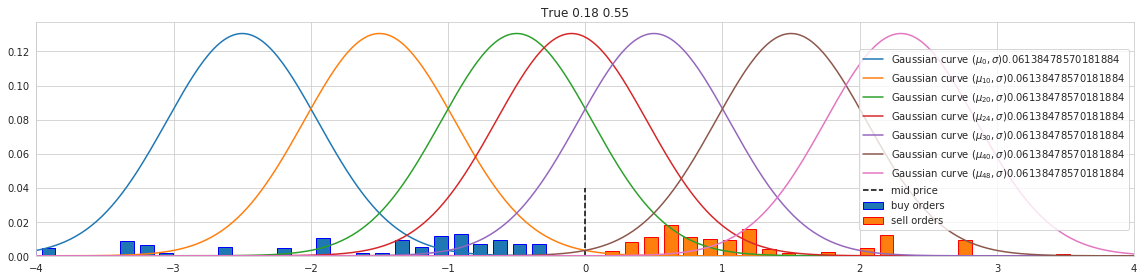

In [10]:
for r, s in [(0.1, 1.0), (1.0, 1.0), (0.1, 0.1), (1.0, 0.1), (0.01, 0.1), (0.18, 0.55)]:

    gdfs = get_gdfs(r, s)
    plot_gdf(buy_orders, sell_orders, gdfs, gdf_numbers_to_plot=[0, 10, 20, 24, 30, 40, 48])
    plt.title('{} {} {}'.format(is_all_gdfs_not_clipped(buy_orders, sell_orders, gdfs), r ,s))
    print(is_all_gdfs_not_clipped(buy_orders, sell_orders, gdfs))

True


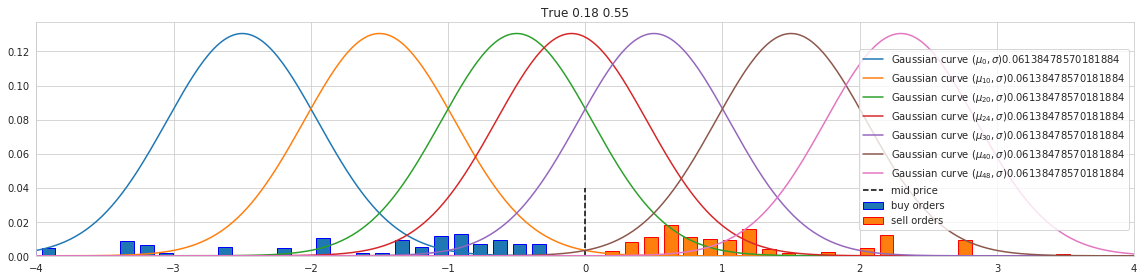

In [11]:
r, s = (0.18, 0.55)
gdfs = get_gdfs(r, s)
plot_gdf(buy_orders, sell_orders, gdfs, gdf_numbers_to_plot=[0, 10, 20, 24, 30, 40, 48])
plt.title('{} {} {}'.format(is_all_gdfs_not_clipped(buy_orders, sell_orders, gdfs), r , s))
print(is_all_gdfs_not_clipped(buy_orders, sell_orders, gdfs))